In [21]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import auc

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Extracting the point collection and the descriptors

In [291]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)
    
results_path = 'testing_results'

if not os.path.exists(results_path): os.mkdir(results_path)
    
obj_names = []

for obj_name, pointCloud, triangles in new_contiguous_point_collection:
    obj_names.append(obj_name)
    
contiguous_names_short = [
    'Recpt\'n',
    'Drvway',
    'Aprtmnt',
    'Wrkst\'n',
    'Kitchen',
    'Hallway',
    'Strwell',
]

contiguous_names = [
    'Reception',
    'Driveway',
    'Apartment',
    'Workstation',
    'Kitchen',
    'Hallway',
    'Stairwell',
]

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:cyan",
    "tab:olive",
    "tab:gray",
    "tab:pink",
    "tab:brown"
]

# The Normal Similarity CDF with varying neighborhood size

In [431]:
"""
For the computation of normal vector similarity:
1. For every keypoint, we get the K nearest neighboring points of and 
2. compute the average cosine similarity of their normals with that of the keypoint.
3. We vary the neighbor size K to see how the normal similarity varies accordingly.
"""

linewidth = 5

raw_norm_cdf_values = []

neighbor_sizes = 50*2**np.arange(0,6)

for i, neighbor_size in enumerate(neighbor_sizes):
    
    t0 = time.time()
    #neighbor_size = 30

    per_neighbor_values = []
    
    # Of all spaces
    for obj_name, pointCloud, triangles in new_contiguous_point_collection:

        nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='kd_tree').fit(pointCloud[:,:3])
        distances, indices = nbrs.kneighbors(pointCloud[:,:3])
        
        max_dist_of_pc = np.mean(np.amax(distances,axis =1))
        print("  Max dist of {} = {:.3f} m".format(obj_name,max_dist_of_pc))
        
        try:
            nearby_normals = pointCloud[indices,3:6]
            refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

            normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
        except Exception as e1:
            print("Error while getting normals,", e1)

        color = np.mean(np.abs(normal_product))
        hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
        CY = np.cumsum(hist/np.sum(hist))
        
        per_neighbor_values.append([
            hist,
            CY,
            values,
            np.trapz(CY, values[1:])
        ])

    print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
    raw_norm_cdf_values.append(per_neighbor_values)
    
with open("properties/raw_cdf_values.pickle",'wb') as f:
    pickle.dump(raw_norm_cdf_values,f)

  Max dist of Reception-Data61-L5.obj = 0.217 m
  Max dist of Driveway.obj = 0.190 m
  Max dist of Apartment.obj = 0.182 m
  Max dist of Workstations-Data61-L4.obj = 0.206 m
  Max dist of Kitchen-Data61-L4.obj = 0.206 m
  Max dist of HallWayToKitchen-Data61-L4.obj = 0.227 m
  Max dist of StairWell-Data61-L4.obj = 0.214 m
Done with 50 in 6.862 seconds
  Max dist of Reception-Data61-L5.obj = 0.447 m
  Max dist of Driveway.obj = 0.382 m
  Max dist of Apartment.obj = 0.353 m
  Max dist of Workstations-Data61-L4.obj = 0.417 m
  Max dist of Kitchen-Data61-L4.obj = 0.416 m
  Max dist of HallWayToKitchen-Data61-L4.obj = 0.473 m
  Max dist of StairWell-Data61-L4.obj = 0.436 m
Done with 200 in 23.387 seconds
  Max dist of Reception-Data61-L5.obj = 0.919 m
  Max dist of Driveway.obj = 0.761 m
  Max dist of Apartment.obj = 0.668 m
  Max dist of Workstations-Data61-L4.obj = 0.805 m
  Max dist of Kitchen-Data61-L4.obj = 0.819 m
  Max dist of HallWayToKitchen-Data61-L4.obj = 0.944 m
  Max dist of Sta

In [ ]:
"""
For the computation of normal vector similarity:
1. For every keypoint, we get the K nearest neighboring points of and 
2. compute the average cosine similarity of their normals with that of the keypoint.
3. We vary the neighbor size K to see how the normal similarity varies accordingly.
"""

linewidth = 5

raw_cdf_values_by_size = []

#neighbor_sizes = 50*2**np.arange(6)

for i, radius in enumerate(np.arange(0.5,3.1,0.5)):
    
    t0 = time.time()
    #neighbor_size = 30

    per_neighbor_values = []
    
    # Of all spaces
    for obj_name, pointCloud, triangles in new_contiguous_point_collection:

        nbrs = NearestNeighbors(n_neighbors=2000, algorithm='kd_tree').fit(pointCloud[:,:3])
        distances, indices = nbrs.kneighbors(pointCloud[:,:3])

        try:
            nearby_normals = pointCloud[indices[np.where(distances<radius)[0]],3:6]
            refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

            normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
        except Exception as e1:
            print("Error while getting normals,", e1)

        color = np.mean(np.abs(normal_product))
        hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
        CY = np.cumsum(hist/np.sum(hist))
        
        per_neighbor_values.append([
            hist,
            CY,
            values,
            np.trapz(CY, values[1:])
        ])

    print("Done with radius {} in {:.3f} seconds".format(radius,time.time()-t0))
    
    raw_norm_cdf_values.append(per_neighbor_values)

with open("properties/raw_cdf_values_by_size.pickle",'wb') as f:
    pickle.dump(raw_cdf_values_by_size,f)

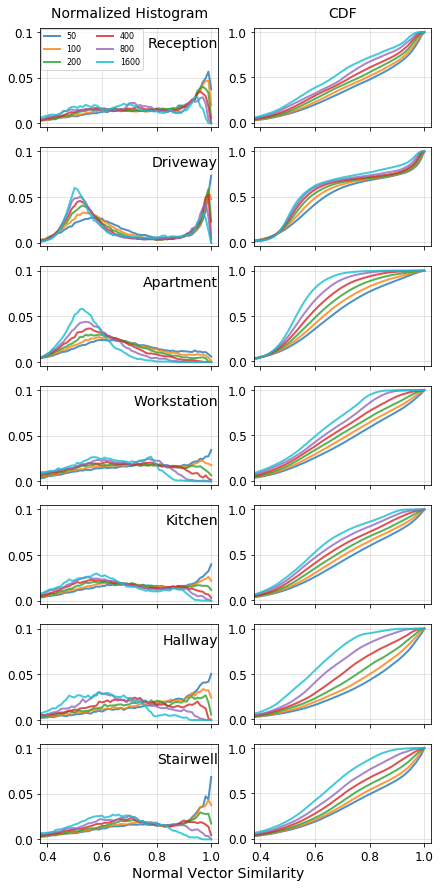

In [560]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, and CDF
"""

with open("properties/raw_cdf_values.pickle",'rb') as f:
    raw_norm_cdf_values = pickle.load(f)

fig=plt.figure(figsize=(7, 15)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

figures_list = []

for n in np.arange(7):    
    figures_list.append([
        fig.add_subplot(7,2,n*2+1), # normalized histogram (estimate PDF)
        fig.add_subplot(7,2,n*2+2) # estimate CDF
    ])
    
raw_sim_dist_values = [] # auc and sim dist ratio

for i_n, per_neighbor_values in enumerate(raw_norm_cdf_values):

    per_neighbor_dist_values = []
    per_neighbor_legends = []
    
    for i_s, [hist, cum_y, values, auc] in enumerate(per_neighbor_values):
        
        ax1, ax2 = figures_list[i_s]

        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(neighbor_sizes[i_n])
        )
            
        ax2.plot(
            values[1:], 
            cum_y, 
            alpha = 0.8, 
            color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(neighbor_sizes[i_n])
        )
        
        per_neighbor_dist_values.append([
            np.sum(hist[90:])/np.sum(hist[:90]),
            np.sum(hist[95:])/np.sum(hist[:95]),
            auc
        ])
        
        ax1.set_ylim(-0.004,0.105)
        ax1.set_xlim(0.375,1.025)
        ax2.set_xlim(0.375,1.025)
        
        if i_s == 0 and i_n == 0:
            ax1.text(
                0.5,1.1,
                "Normalized Histogram",
                horizontalalignment='center',
                fontsize = 14,
                transform=ax1.transAxes                
            )
            ax2.text(
                0.5,1.1,                
                "CDF",
                horizontalalignment='center',
                fontsize = 14,
                transform=ax2.transAxes
            )

        if i_n == len(neighbor_sizes)-1:
            ax1.text(
                1.0,.8,contiguous_names[i_s],
                horizontalalignment='right',
                fontsize = 14,
                transform=ax1.transAxes
            )
        
        ax1.set_xticks(np.arange(0.4,1.1,0.2))
        ax2.set_xticks(np.arange(0.4,1.1,0.2))
        ax1.set_yticks(np.arange(0.0,0.11,0.05))
        ax2.set_yticks(np.arange(0.0,1.1,0.5))

        if i_s != 6:# and i_n != 0: 
            ax1.set_xticklabels([])
            ax2.set_xticklabels([])   
        else:
            ax1.set_xticklabels(np.around(np.arange(0.4,1.1,0.2), decimals = 1), fontsize = 12)
            ax2.set_xticklabels(np.around(np.arange(0.4,1.1,0.2), decimals = 1), fontsize = 12)
            if i_n == 0: 
                ax1.text(
                    1.0,-0.35,"Normal Vector Similarity",
                    horizontalalignment='center',
                    fontsize = 14,
                    transform=ax1.transAxes
                )
            
        ax1.set_yticklabels(np.arange(0.0,0.11,0.05), fontsize = 12)
        ax2.set_yticklabels(np.arange(0.0,1.1,0.5), fontsize = 12)
        
        ax1.grid(alpha=0.4)
        ax2.grid(alpha=0.4)
            
        if i_n == len(neighbor_sizes)-1 and i_s == 0:
            ax1.legend(#loc = "upper left", 
                ncol = 2, fontsize = 8, bbox_to_anchor=(0.6, 1.03))

    #print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
    raw_sim_dist_values.append(per_neighbor_dist_values)
    
#plt.show()
plt.savefig('properties/raw-norm-sim-hist-cdf.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/raw-norm-sim-hist-cdf.png', format='png', dpi=300,bbox_inches = 'tight')


(6, 7, 3)
AUC 0.29985650403790964 0.0
Ratio 0.5566694185635098 0.0


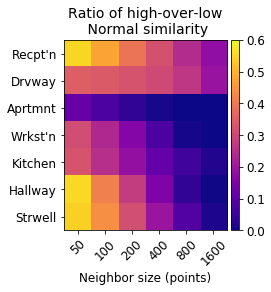

In [561]:
fig=plt.figure(figsize=(4,3.5))

raw_sim_dist_values = np.asarray(raw_sim_dist_values)
print(raw_sim_dist_values.shape)
print("AUC",np.max(raw_sim_dist_values[:,:,1]),np.min(raw_sim_dist_values[:,:,1]))
print("Ratio",np.max(raw_sim_dist_values[:,:,0]),np.min(raw_sim_dist_values[:,:,0]))

#fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax1 = fig.add_subplot(111)
#fig.figsize(8,3.5)

im1 = ax1.imshow(
    raw_sim_dist_values[:,:,0].T, 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);
ax1.set_xticks(np.arange(len(neighbor_sizes)))
ax1.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax1.set_yticks(np.arange(len(contiguous_names)))
ax1.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)
ax1.set_title("Ratio of high-over-low\n Normal similarity", fontsize = 14)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax = cax1, format="%.1f")
cbar1.ax.set_yticklabels(np.arange(0,np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)+0.1,0.1, dtype = np.float32),fontsize = 12);

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
plt.savefig('properties/ratio-norm-sim-90.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/ratio-norm-sim-90.png', format='png', dpi=300,bbox_inches = 'tight')


(6, 7, 3)
AUC 0.29985650403790964 0.0
Ratio 0.5566694185635098 0.0


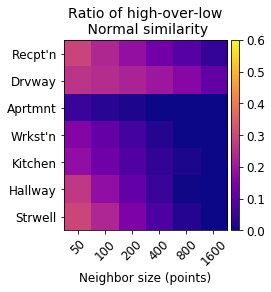

In [562]:
fig=plt.figure(figsize=(4,3.5))

raw_sim_dist_values = np.asarray(raw_sim_dist_values)
print(raw_sim_dist_values.shape)
print("AUC",np.max(raw_sim_dist_values[:,:,1]),np.min(raw_sim_dist_values[:,:,1]))
print("Ratio",np.max(raw_sim_dist_values[:,:,0]),np.min(raw_sim_dist_values[:,:,0]))

#fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax1 = fig.add_subplot(111)
#fig.figsize(8,3.5)

im1 = ax1.imshow(
    raw_sim_dist_values[:,:,1].T, 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);
ax1.set_xticks(np.arange(len(neighbor_sizes)))
ax1.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax1.set_yticks(np.arange(len(contiguous_names)))
ax1.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)
ax1.set_title("Ratio of high-over-low\n Normal similarity", fontsize = 14)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax = cax1, format="%.1f")
cbar1.ax.set_yticklabels(np.arange(0,np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)+0.1,0.1, dtype = np.float32),fontsize = 12);

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
plt.savefig('properties/ratio-norm-sim-95.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/ratio-norm-sim-95.png', format='png', dpi=300,bbox_inches = 'tight')


(6, 7, 2)
AUC 0.46490392401762304 0.21104894310175018
Ratio 0.5566694185635098 0.0


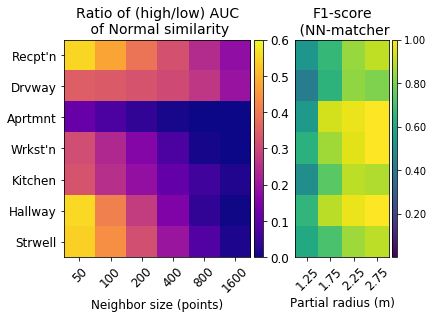

In [517]:
fig=plt.figure(figsize=(4,3.5))

raw_sim_dist_values = np.asarray(raw_sim_dist_values)
print(raw_sim_dist_values.shape)
print("AUC",np.max(raw_sim_dist_values[:,:,1]),np.min(raw_sim_dist_values[:,:,1]))
print("Ratio",np.max(raw_sim_dist_values[:,:,0]),np.min(raw_sim_dist_values[:,:,0]))

#fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax1 = 
#fig.figsize(8,3.5)

im1 = ax1.imshow(
    raw_sim_dist_values[:,:,0].T, 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);
ax1.set_xticks(np.arange(len(neighbor_sizes)))
ax1.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax1.set_yticks(np.arange(len(contiguous_names)))
ax1.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax1.set_xlabel("Neighbor size (points)",fontsize = 12)
ax1.set_title("Ratio of (high/low) AUC\n of Normal similarity", fontsize = 14)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax = cax1, format="%.1f")
cbar1.ax.set_yticklabels(np.arange(0,np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)+0.1,0.1, dtype = np.float32),fontsize = 12);

im2 = ax2.imshow(
    per_space_score[2:,0].T,
    vmin=0.0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

ax2.set_title("F1-score\n (NN-matcher", fontsize = 14)
ax2.set_xticks(np.arange(4))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5)[2:], rotation=45, fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
ax2.set_yticks([])
ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

# Create divider for existing axes instance
divider2 = make_axes_locatable(ax2)
# Append axes to the right of ax3, with 20% width of ax3
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar2 = plt.colorbar(im2, cax=cax2, ticks=np.arange(0.2,1.1,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
#cbar2.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 12)

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
plt.savefig('properties/ratio-norm-sim.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/ratio-norm-sim.png', format='png', dpi=300,bbox_inches = 'tight')


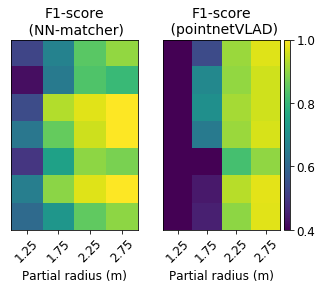

In [568]:
fig = plt.figure(figsize=(5,3.5))

#fig, (ax2, ax3) = #plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1.2]})

#fig3 = plt.figure(constrained_layout=True)
#gs = fig3.add_gridspec(3, 3)
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
#fig.figsize(8,3.5)

im2 = ax2.imshow(
    per_space_score[2:,0].T,
    vmin=0.4, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

ax2.set_title("F1-score\n (NN-matcher)", fontsize = 14)
ax2.set_xticks(np.arange(4))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5)[2:], rotation=45, fontsize = 12)
ax2.set_xlabel("Partial radius (m)",fontsize = 12)
#ax2.set_yticks(np.arange(len(contiguous_names)))
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
ax2.set_yticks([])
ax2.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

im3 = ax3.imshow(
    pointnetvlad_per_space_score[4::2,0].T,
    vmin=0.4, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

ax3.set_title("F1-score\n (pointnetVLAD)", fontsize = 14)
ax3.set_xticks(np.arange(4))
ax3.set_xticklabels(np.arange(1.25, 3.1, 0.5), rotation=45, fontsize = 12)
ax3.set_xlabel("Partial radius (m)",fontsize = 12)
ax3.set_yticks([])
ax3.set_yticklabels([])
#ax2.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

# Create divider for existing axes instance
divider3 = make_axes_locatable(ax3)
# Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, ticks=np.arange(0.4,1.1,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar3.ax.set_yticklabels(np.around(np.arange(0.4,1.1,0.2), decimals = 2),fontsize = 12);

"""
ax2.set_xticks(np.arange(0,6))
ax2.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax2.set_xlabel('Partial radius', fontsize = 14)
ax2.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax2.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(
"""
#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
#plt.show()
plt.savefig('properties/f1-scores-no-label-0.4.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/f1-scores-no-label-0.4.png', format='png', dpi=300,bbox_inches = 'tight')


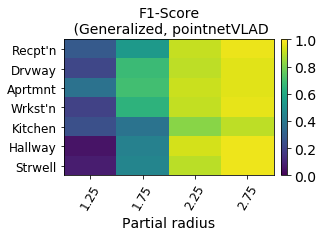

In [500]:
fig=plt.figure(figsize=(4,2.5))

with open(RESULTS_FOLDER + "summary_results.pickle",'rb') as f:
    [pointnetvlad_results, pointnetvlad_per_space_score] = pickle.load(f)

ax1 = fig.add_subplot(1,1,1)

im1 = ax1.imshow(
    pointnetvlad_per_space_score[4::2,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, ticks=np.arange(0,1.6,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar1.ax.set_yticklabels(np.arange(0,1.6,0.2, dtype = np.float32),fontsize = 14)

#cbar = plt.colorbar(ticks = np.arange(0,1.1,0.2))
#cbar.ax.set_ylabel("F1-score", fontsize = 14)
#cbar.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 14)

ax1.set_title('F1-Score\n (Generalized, pointnetVLAD', fontsize = 14)
ax1.set_xticks(np.arange(4))
ax1.set_xticklabels(np.arange(1.25, 3.1, 0.5),rotation = 60,fontsize = 12)
ax1.set_xlabel('Partial radius', fontsize = 14)
ax1.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax1.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(

#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.show()


# Looking into the impact of generalizations to Normal similarity

In [355]:
linewidth = 5

norm_cdf_values = []

neighbor_sizes = 50*2**np.arange(6)

for i, neighbor_size in enumerate(neighbor_sizes):
    
    t0 = time.time()
    #neighbor_size = 30

    per_neighbor_values = []
    
    for trial in np.arange(5):
        
        per_trial_values = []
            
        with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
            ransac_trial_point_collection = pickle.load(f)

        for obj_name, pointCloud, triangles in ransac_trial_point_collection:

            nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='kd_tree').fit(pointCloud[:,:3])
            distances, indices = nbrs.kneighbors(pointCloud[:,:3])

            try:
                nearby_normals = pointCloud[indices,3:6]
                refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

                normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
            except Exception as e1:
                print("Error while getting normals,", e1)

            color = np.mean(np.abs(normal_product))
            hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
            CY = np.cumsum(hist/np.sum(hist))

            per_trial_values.append([
                hist,
                CY,
                values,
                np.trapz(CY, values[1:])
            ])
            
        per_neighbor_values.append(per_trial_values)

        print(trial,"  Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
    norm_cdf_values.append(per_neighbor_values)


0   Done with 50 in 6.297 seconds
1   Done with 50 in 12.481 seconds
2   Done with 50 in 18.952 seconds
3   Done with 50 in 25.713 seconds
4   Done with 50 in 32.200 seconds
0   Done with 100 in 11.653 seconds
1   Done with 100 in 23.309 seconds
2   Done with 100 in 34.558 seconds
3   Done with 100 in 46.301 seconds
4   Done with 100 in 58.033 seconds
0   Done with 200 in 22.658 seconds
1   Done with 200 in 45.228 seconds
2   Done with 200 in 66.968 seconds
3   Done with 200 in 89.111 seconds
4   Done with 200 in 111.189 seconds
0   Done with 400 in 44.187 seconds
1   Done with 400 in 88.117 seconds
2   Done with 400 in 131.167 seconds
3   Done with 400 in 174.304 seconds
4   Done with 400 in 217.723 seconds
0   Done with 800 in 88.561 seconds
1   Done with 800 in 177.923 seconds
2   Done with 800 in 264.154 seconds
3   Done with 800 in 351.904 seconds
4   Done with 800 in 439.547 seconds
0   Done with 1600 in 177.738 seconds
1   Done with 1600 in 356.332 seconds
2   Done with 1600 in 

In [364]:
#ransac_norm_cdf_values = norm_cdf_values

with open("properties/ransac_cdf_values.pickle",'wb') as f:
    pickle.dump(ransac_norm_cdf_values,f)

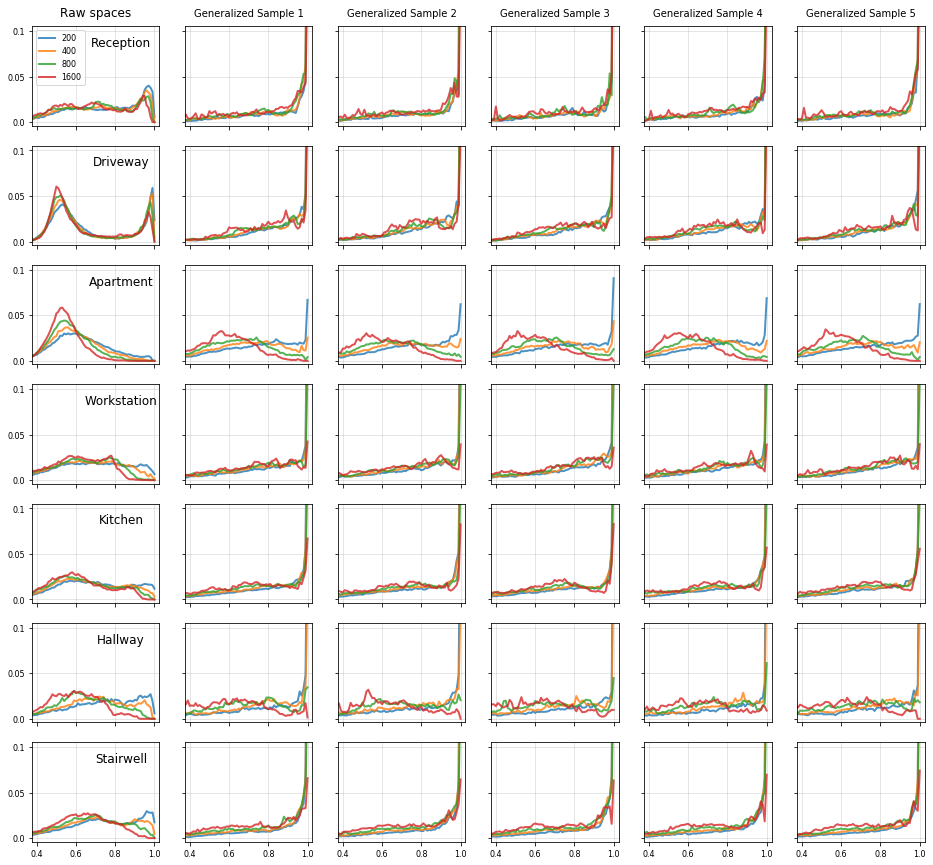

In [557]:
"""
Plotting the (estimate) PDF, i.e. normalized histogram, for Raw and Generalized spaces
"""

with open("properties/raw_cdf_values.pickle",'rb') as f:
    raw_norm_cdf_values = pickle.load(f)

fig=plt.figure(figsize=(16, 15)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

figures_list = []

neighbor_sizes = 50*2**np.arange(6)

for n in np.arange(7):    
    figures_list.append([
        fig.add_subplot(7,6,n*6+1),
        fig.add_subplot(7,6,n*6+2),
        fig.add_subplot(7,6,n*6+3),
        fig.add_subplot(7,6,n*6+4),
        fig.add_subplot(7,6,n*6+5),
        fig.add_subplot(7,6,n*6+6),
    ])
    
for i_n, per_neighbor_values in enumerate(raw_norm_cdf_values[2:]):

    per_neighbor_dist_values = []
    per_neighbor_legends = []
    
    for i_s, [hist, cum_y, values, auc] in enumerate(per_neighbor_values):
        
        ax1 = figures_list[i_s][0]

        #color = np.mean(np.abs(normal_product))
        ax1.plot(
            values[1:], 
            hist/np.sum(hist), 
            alpha = 0.8, 
            color = colors[i_n], #mpl.cm.viridis(color), 
            linewidth = 2,
            label = str(neighbor_sizes[i_n+2])
        )
        
        ax1.set_ylim(-0.004,0.105)
        ax1.set_xlim(0.375,1.025)
        
        if i_s == 0 and i_n == 0:
            ax1.text(
                0.5,1.1,
                "Raw spaces",
                horizontalalignment='center',
                fontsize = 12,
                transform=ax1.transAxes                
            )

        if i_n == len(neighbor_sizes)-3:
            ax1.text(
                .7,.8,contiguous_names[i_s],
                horizontalalignment='center',
                fontsize = 12,
                transform=ax1.transAxes
            )
        
        ax1.set_xticks(np.arange(0.4,1.1,0.2))
        ax1.set_yticks(np.arange(0.0,0.11,0.05))

        if i_s != 6: 
            ax1.set_xticklabels([])
        else:
            ax1.set_xticklabels(np.around(np.arange(0.4,1.1,0.2), decimals = 1), fontsize = 8)

        ax1.set_yticklabels(np.arange(0.0,0.11,0.05), fontsize = 8)
        
        ax1.grid(alpha=0.4)
            
        if i_n == len(neighbor_sizes)-3 and i_s == 0:
            ax1.legend(loc = "upper left", ncol = 1, fontsize = 8)#, bbox_to_anchor=(0, 1.3))
    

# RANSAC
ransac_sim_dist_values = [] # auc and sim dist ratio

for i_n, per_neighbor_values in enumerate(ransac_norm_cdf_values):

    per_neighbor_dist_values = []
    
    for i_t, per_trial_values in enumerate(per_neighbor_values):
        
        per_trial_dist_values = []
    
        for i_s, [hist, cum_y, values, auc] in enumerate(per_trial_values):
            
            per_trial_dist_values.append([
                np.sum(hist[90:])/np.sum(hist[:90]),
                np.sum(hist[95:])/np.sum(hist[:95]),
            ])
            
            if i_n < 2: continue

            ax = figures_list[i_s][i_t+1]

            #color = np.mean(np.abs(normal_product))
            ax.plot(
                values[1:], 
                hist/np.sum(hist), 
                alpha = 0.8, 
                color = colors[i_n-2], #mpl.cm.viridis(color), 
                linewidth = 2,
                label = str(neighbor_sizes[i_n])
            )
            
            ax.grid(alpha=0.4)
            ax.set_ylim(-0.004,0.105)
            ax.set_xlim(0.375,1.025)
            
            ax.set_xticks(np.arange(0.4,1.1,0.2))
            ax.set_yticks(np.arange(0.0,0.11,0.05))
            
            if i_s == 0 and i_n == 4:
                ax.text(
                    0.5,1.1,
                    "Generalized Sample "+str(i_t+1),
                    horizontalalignment='center',
                    fontsize = 10,
                    transform=ax.transAxes                
                )
            
            if i_s != 6: 
                ax.set_xticklabels([])
            else:
                ax.set_xticklabels(np.around(np.arange(0.4,1.1,0.2), decimals = 1), fontsize = 8)
                
            #ax.set_yticklabels(np.arange(0.0,0.11,0.05), fontsize = 8)
            ax.set_yticklabels([])
            
            """
            if i_n == len(neighbor_sizes)-1 and i_s == 0:
                ax1.legend(loc = "upper left", ncol = 8, fontsize = 10, bbox_to_anchor=(0, 1.3))
                #ax2.legend(loc = "upper left", ncol = 2, fontsize = 8)
            """
            
        per_neighbor_dist_values.append(per_trial_dist_values)
        
    ransac_sim_dist_values.append(per_neighbor_dist_values)
    
    #sim_dist_values.append(per_neighbor_dist_values)

plt.savefig('properties/generalized-norm-sim.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/generalized-norm-sim.png', format='png', dpi=300,bbox_inches = 'tight')

#plt.show()


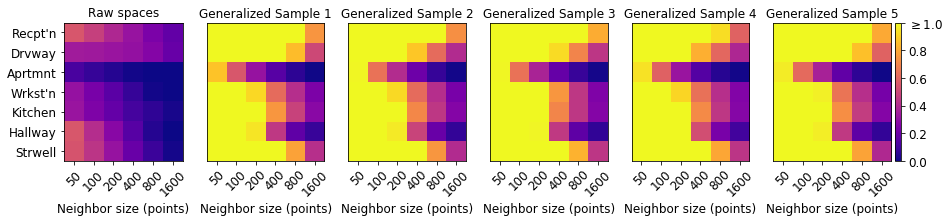

In [558]:
from matplotlib import gridspec

fig=plt.figure(figsize=(15,3.5))

ransac_sim_dist_values = np.asarray(ransac_sim_dist_values)
raw_sim_dist_values = np.asarray(raw_sim_dist_values)

gs = gridspec.GridSpec(1, 6, width_ratios=[1.01,1, 1, 1, 1, 1.085]) 

ax0 = plt.subplot(gs[0])#fig.add_subplot(1,6,1)

im0 = ax0.imshow(
    raw_sim_dist_values[:,:,0].T, 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=1.0# np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);

ax0.set_xticks(np.arange(len(neighbor_sizes)))
ax0.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax0.set_xlabel("Neighbor size (points)",fontsize = 12)
ax0.set_title("Raw spaces", fontsize = 12)

ax0.set_yticks(np.arange(len(contiguous_names)))
ax0.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

for i_t in np.arange(ransac_sim_dist_values.shape[1]):
    
    ax = plt.subplot(gs[i_t+1])#fig.add_subplot(1,6,i_t+2)
    ax.set_aspect(1)

    im = ax.imshow(
        ransac_sim_dist_values[:,i_t,:,0].T, 
        cmap=mpl.cm.plasma,
        vmin=0.0, vmax=1.0 #np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
    );
    
    ax.set_xticks(np.arange(len(neighbor_sizes)))
    ax.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
    ax.set_xlabel("Neighbor size (points)",fontsize = 12)
    
    ax.set_yticks([])
    ax.set_title("Generalized Sample "+str(i_t+1), fontsize = 12)

    """    
    if i_t == 0: 
        ax.set_yticks(np.arange(len(contiguous_names)))
        ax.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
    
    
    #ax.set_title("Ratio of (high/low) AUC\n of Normal similarity", fontsize = 14)
    """
    if i_t == np.arange(ransac_sim_dist_values.shape[1])[-1]:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax = cax, format="%.1f")
        cbar.ax.set_yticklabels(np.append(np.arange(0,0.9,0.2, dtype = np.float32),'$\geq 1.0$'),fontsize = 12);

#plt.savefig('properties/ratio-norm-sim-v_f1-score.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
#plt.savefig('properties/ratio-norm-sim-v_f1-score.png', format='png', dpi=300,bbox_inches = 'tight')


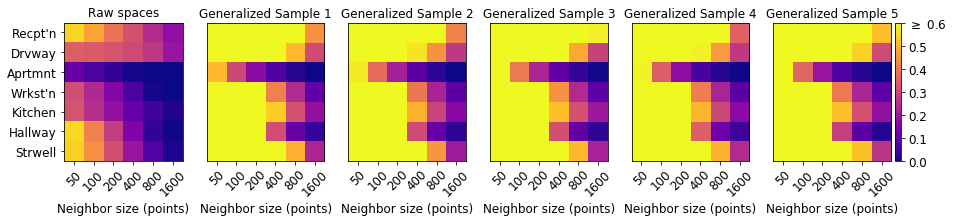

In [572]:
from matplotlib import gridspec

fig=plt.figure(figsize=(15,3.5))

ransac_sim_dist_values = np.asarray(ransac_sim_dist_values)
raw_sim_dist_values = np.asarray(raw_sim_dist_values)

gs = gridspec.GridSpec(1, 6, width_ratios=[1.01,1, 1, 1, 1, 1.085]) 

ax0 = plt.subplot(gs[0])#fig.add_subplot(1,6,1)

im0 = ax0.imshow(
    raw_sim_dist_values[:,:,0].T, 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.6# np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
);

ax0.set_xticks(np.arange(len(neighbor_sizes)))
ax0.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
ax0.set_xlabel("Neighbor size (points)",fontsize = 12)
ax0.set_title("Raw spaces", fontsize = 12)

ax0.set_yticks(np.arange(len(contiguous_names)))
ax0.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);

for i_t in np.arange(ransac_sim_dist_values.shape[1]):
    
    ax = plt.subplot(gs[i_t+1])#fig.add_subplot(1,6,i_t+2)
    ax.set_aspect(1)

    im = ax.imshow(
        ransac_sim_dist_values[:,i_t,:,1].T, 
        cmap=mpl.cm.plasma,
        vmin=0.0, vmax=0.6 #np.around(np.max(raw_sim_dist_values[:,:,0]),decimals = 1)
    );
    
    ax.set_xticks(np.arange(len(neighbor_sizes)))
    ax.set_xticklabels(neighbor_sizes, rotation=45, fontsize = 12)
    ax.set_xlabel("Neighbor size (points)",fontsize = 12)
    
    ax.set_yticks([])
    ax.set_title("Generalized Sample "+str(i_t+1), fontsize = 12)

    """    
    if i_t == 0: 
        ax.set_yticks(np.arange(len(contiguous_names)))
        ax.set_yticklabels(contiguous_names_short,rotation=0, fontsize = 12);
    
    
    #ax.set_title("Ratio of (high/low) AUC\n of Normal similarity", fontsize = 14)
    """
    if i_t == np.arange(ransac_sim_dist_values.shape[1])[-1]:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax = cax, format="%.1f")
        cbar.ax.set_yticklabels(np.append(np.arange(0,0.6,0.1, dtype = np.float32),'$\geq$ 0.6'),fontsize = 12);

plt.savefig('properties/generalized-ratio-norm-sim.pdf', format='pdf', dpi=300,bbox_inches = 'tight')
plt.savefig('properties/generalized-ratio-norm-sim.png', format='png', dpi=300,bbox_inches = 'tight')


[0.65242409 0.55173603 0.51170431 0.47712681 0.44983529 0.42835473
 0.4087256 ]
[0.36118218 0.34972496 0.34398905 0.34088661 0.33789278 0.33294308
 0.32914614]
[0.16234067 0.11777791 0.09214234 0.07525089 0.06248724 0.05325623
 0.0454278 ]
[0.39677967 0.31266136 0.26713396 0.23688612 0.21476332 0.19283468
 0.17693866]
[0.41529291 0.32744867 0.28111816 0.25173688 0.22974597 0.2118058
 0.19777853]
[0.70155988 0.55666942 0.46663704 0.41301788 0.36649757 0.33222306
 0.30579739]
[0.63541514 0.54370356 0.48335809 0.43942277 0.40368295 0.37150754
 0.33936799]


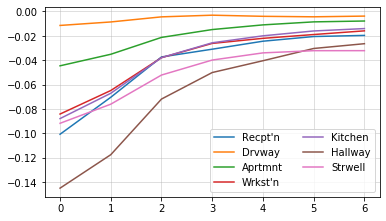

In [234]:
fig=plt.figure(figsize=(6,3.5))

plt.grid(alpha = 0.5)

for i, auc_ratio in enumerate(sim_dist_values[:,:,0].T):
    print(auc_ratio)
    plt.plot(
        np.gradient(auc_ratio),
        label = contiguous_names_short[i]
    )
    
plt.legend(ncol = 2)

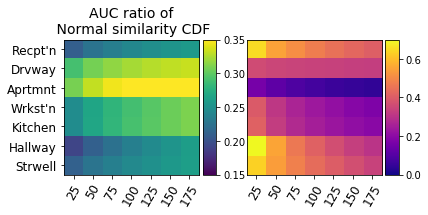

In [177]:
fig=plt.figure(figsize=(6,2.5))

ax1 = fig.add_subplot(1,2,1)

#auc_values = np.asarray(auc_values)

im1 = ax1.imshow(
    sim_dist_values[:,:,1].T, 
    cmap=mpl.cm.viridis,
    vmin=0.15, vmax=0.35
);
plt.xticks(np.arange(7),neighbor_sizes, rotation=60, fontsize = 12)
plt.yticks(np.arange(7),contiguous_names_short,rotation=0, fontsize = 12);

plt.title("AUC ratio of\n Normal similarity CDF", fontsize = 14)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="10%", pad=0.05)

cbar1 = plt.colorbar(im1, cax = cax1)#, ticks=np.arange(0,1.1,0.2), format="%.2f")
#cbar.ax.set_ylabel("F1-score", fontsize = 14)

ax2 = fig.add_subplot(1,2,2)

#auc_values = np.asarray(auc_values)

im2 = ax2.imshow(
    sim_dist_values[:,:,0].T, 
    cmap=mpl.cm.plasma,
    vmin=0.0, vmax=0.7
);
plt.xticks(np.arange(7),neighbor_sizes, rotation=60, fontsize = 12)
plt.yticks([])#,rotation=0, fontsize = 12);

#plt.title("Normal similarity PDF Ratio", fontsize = 14)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="10%", pad=0.05)

cbar2 = plt.colorbar(im2, cax = cax2)


Done with 10 in 2.558 seconds
Done with 30 in 4.732 seconds
Done with 50 in 6.779 seconds
Done with 70 in 9.088 seconds


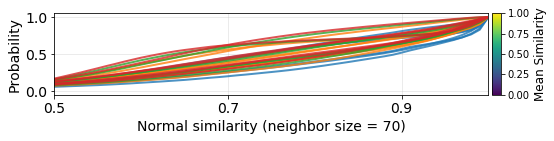

In [90]:
fig=plt.figure(figsize=(8, 1.5)) ##fig=plt.figure(figsize=(80, 80))

linewidth = 5

auc_values = []

for i, neighbor_size in enumerate([10,30,50,70]):
    
    t0 = time.time()
    #neighbor_size = 30

    per_neighbor_auc = []
    
    # Of all spaces
    for obj_name, pointCloud, triangles in new_contiguous_point_collection:

        nbrs = NearestNeighbors(n_neighbors=neighbor_size, algorithm='kd_tree').fit(pointCloud[:,:3])
        distances, indices = nbrs.kneighbors(pointCloud[:,:3])

        try:
            nearby_normals = pointCloud[indices,3:6]
            refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],neighbor_size,axis=0),nearby_normals.shape)

            normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)
        except Exception as e1:
            print("getLocalSelfSimilarity: Error while getting normals,", e1)

        color = np.mean(np.abs(normal_product))
        hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
        CY = np.cumsum(hist/np.sum(hist))
        plt.plot(
            values[1:], 
            CY, 
            alpha = 0.8, 
            color = colors[i], #mpl.cm.viridis(color), 
            linewidth = 2
        )
        
        per_neighbor_auc.append(np.trapz(CY, values[1:]))

    print("Done with {} in {:.3f} seconds".format(neighbor_size,time.time()-t0))
    
    auc_values.append(per_neighbor_auc)

plt.xlabel("Normal similarity (neighbor size = {})".format(neighbor_size), fontsize = 14)
plt.xlim(0.5,1)
plt.xticks(np.arange(0.5,1.0,0.2),fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(alpha=0.3)
#plt.legend([p1, p2],['Sphere','Cube'],fontsize = 14);
plt.ylabel('Probability', fontsize = 14)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="2%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.viridis, orientation='vertical')
cb1.set_label('Mean Similarity', fontsize = 12)
plt.gcf().add_axes(ax_cb)

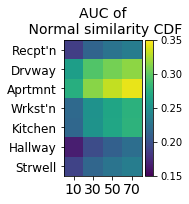

In [94]:
fig=plt.figure(figsize=(6,2.5))

ax = fig.add_subplot(1,2,1)

auc_values = np.asarray(auc_values)

im1 = ax.imshow(
    auc_values.T, 
    cmap=mpl.cm.viridis,
    vmin=0.15, vmax=0.35
);
plt.xticks([0,1,2,3],[10,30,50,70], fontsize = 14)
plt.yticks(np.arange(7),contiguous_names_short,rotation=0, fontsize = 12);

plt.title("AUC of\n Normal similarity CDF", fontsize = 14)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)

cbar = plt.colorbar(im1, cax = cax)#, ticks=np.arange(0,1.1,0.2), format="%.2f")
#cbar.ax.set_ylabel("F1-score", fontsize = 14)


# Performance Scores

In [92]:
per_space_score = []
perf_scores = []

#desired_r = [0.5, 1.0, 3.0]

for radius, partial_errors in ransac_errors:

    score_map = np.zeros((7,7))

    for score in partial_errors:
        score_map[int(score[0]),int(score[3])]+=1
        
    macro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    micro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='micro')
    mcc = matthews_corrcoef(partial_errors[:,0],partial_errors[:,3])
    ave_prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average=None)
    ave_recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average=None)
    
    per_space_score.append([
        f1_score(partial_errors[:,0],partial_errors[:,3],average=None),
        prec_score,
        recl_score
    ])
    
    perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])
    
per_space_score = np.asarray(per_space_score)
perf_scores = np.asarray(perf_scores)

#plt.savefig('plots/partials-Raw-heatmaps.pdf', format='pdf', dpi=300,bbox_inches = 'tight')

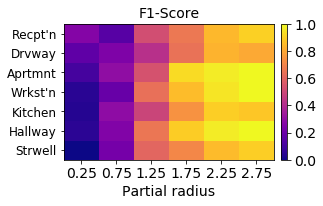

In [93]:
fig=plt.figure(figsize=(4,2.5))

ax1 = fig.add_subplot(1,1,1)

im1 = ax1.imshow(
    per_space_score[:,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.plasma
)

# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, ticks=np.arange(0,1.6,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar1.ax.set_yticklabels(np.arange(0,1.6,0.2, dtype = np.float32),fontsize = 14)

#cbar = plt.colorbar(ticks = np.arange(0,1.1,0.2))
#cbar.ax.set_ylabel("F1-score", fontsize = 14)
#cbar.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 14)

ax1.set_title('F1-Score', fontsize = 14)
ax1.set_xticks(np.arange(0,6))
ax1.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax1.set_xlabel('Partial radius', fontsize = 14)
ax1.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax1.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(

#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.show()


# RANSAC Results

In [64]:
results_partials = [[],[]] 

raw_errors = []    
ransac_errors = []

for radius in np.arange(0.25, 3.1, 0.5):

    try:
        with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    ransac_errors.append([
        radius,
        partial_errors_pool
    ])
    
    results_partials[1].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    try:
        with bz2.BZ2File('testing_results/partial/raw_{}_partial_scores.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 
            
    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Raw) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Raw) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    results_partials[0].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    raw_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open('testing_results/partial/results_partials_nn_matcher.pickle', 'wb') as f:
    pickle.dump(results_partials,f)

/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.25 (Ransac) P1 Error Rate: 0.8383458646616542
   (Ransac) P2 Error Rate: 6.897 (± 2.967)
0.25 (Raw) P1 Error Rate: 0.8458646616541353
   (Raw) P2 Error Rate: 4.972 (± 1.552)
0.75 (Ransac) P1 Error Rate: 0.7593984962406015
   (Ransac) P2 Error Rate: 4.094 (± 3.706)
0.75 (Raw) P1 Error Rate: 0.6917293233082706
   (Raw) P2 Error Rate: 3.748 (± 3.658)
1.25 (Ransac) P1 Error Rate: 0.4473684210526316
   (Ransac) P2 Error Rate: 1.509 (± 1.841)
1.25 (Raw) P1 Error Rate: 0.05639097744360902
   (Raw) P2 Error Rate: 1.043 (± 1.182)
1.75 (Ransac) P1 Error Rate: 0.22556390977443608
   (Ransac) P2 Error Rate: 1.205 (± 1.277)
1.75 (Raw) P1 Error Rate: 0.0
   (Raw) P2 Error Rate: 0.897 (± 0.642)
2.25 (Ransac) P1 Error Rate: 0.09774436090225563
   (Ransac) P2 Error Rate: 1.253 (± 0.876)
Error getting Raw scores for 2.25
2.75 (Ransac) P1 Error Rate: 0.07518796992481203
   (Ransac) P2 Error Rate: 1.402 (± 0.825)
Error getting Raw scores for 2.75


# PointnetVLAD results

In [491]:
RESULTS_FOLDER="testing_results/pointnetvlad_prod/"
if not os.path.exists(RESULTS_FOLDER): os.mkdir(RESULTS_FOLDER)   
    
pickle_file = 'partial_results_updated_refs.pickle'

try:
    with open(RESULTS_FOLDER + pickle_file,'rb') as pickle_output:
        results_pickle = pickle.load(pickle_output)
except:
    print("No results.")
    
pointnetvlad_results = []
pointnetvlad_per_space_score = []

for radius, recall, intra_dist, test_recall in results_pickle:
    pointnetvlad_results.append([
        radius,
        recall[0],
        intra_dist[0]
    ])
    
    count_diff = 0

    errors_pool = []
    
    for m, n, top1_obj_cands in test_recall:
        if len(errors_pool) == 0:
            errors_pool = top1_obj_cands
        else:
            errors_pool = np.concatenate((errors_pool,top1_obj_cands), axis = 0)
            
        #print("  ",m,n,len(top1_obj_cands),len(errors_pool))
        
    macro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='macro')    
    micro_score = f1_score(errors_pool[:,0],errors_pool[:,1],average='micro')
    mcc = matthews_corrcoef(errors_pool[:,0],errors_pool[:,1])
    ave_prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    prec_score = precision_score(errors_pool[:,0],errors_pool[:,1],average=None)
    ave_recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average='macro')
    recl_score = recall_score(errors_pool[:,0],errors_pool[:,1],average=None)
    
    pointnetvlad_per_space_score.append([
        f1_score(errors_pool[:,0],errors_pool[:,1],average=None),
        prec_score,
        recl_score
    ])

    1 - count_diff/len(test_recall)
    
    
pointnetvlad_results = np.asarray(pointnetvlad_results)
pointnetvlad_per_space_score = np.asarray(pointnetvlad_per_space_score)

with open(RESULTS_FOLDER + "summary_results.pickle",'wb') as f:
    pickle.dump([pointnetvlad_results, pointnetvlad_per_space_score],f)

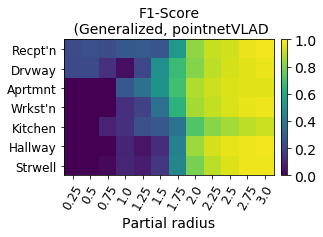

In [492]:
fig=plt.figure(figsize=(4,2.5))

with open(RESULTS_FOLDER + "summary_results.pickle",'rb') as f:
    [pointnetvlad_results, pointnetvlad_per_space_score] = pickle.load(f)

ax1 = fig.add_subplot(1,1,1)

im1 = ax1.imshow(
    pointnetvlad_per_space_score[:,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.viridis
)

# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, ticks=np.arange(0,1.6,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar1.ax.set_yticklabels(np.arange(0,1.6,0.2, dtype = np.float32),fontsize = 14)

#cbar = plt.colorbar(ticks = np.arange(0,1.1,0.2))
#cbar.ax.set_ylabel("F1-score", fontsize = 14)
#cbar.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 14)

ax1.set_title('F1-Score\n (Generalized, pointnetVLAD', fontsize = 14)
ax1.set_xticks(np.arange(len(results_pickle)))
ax1.set_xticklabels(np.arange(0.25, 3.1, 0.25),rotation = 60,fontsize = 12)
ax1.set_xlabel('Partial radius', fontsize = 14)
ax1.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax1.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(

#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.show()


Text(0.5, 1.0, 'NN-matcher')

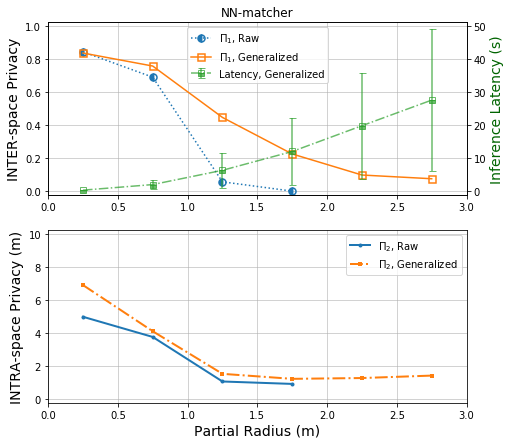

In [13]:
fig=plt.figure(figsize=(7.5, 7))

with open('testing_results/partial/results_partials_nn_matcher.pickle', 'rb') as f:
    results_partials = pickle.load(f)

RawNN = np.asarray(results_partials[0])
RansacNN = np.asarray(results_partials[1])
linewidth = 2.0
markersize = 2.0

ax2 = fig.add_subplot(212)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)

ax2.set_ylabel("INTRA-space Privacy (m)", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

ax2.plot(
    RawNN[:,0],
    RawNN[:,2], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Raw"
)
ax2.plot(
    RansacNN[:,0],
    RansacNN[:,2],
    '-.s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Generalized"
)

ax2.legend(loc = "upper right", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

ax1 = fig.add_subplot(211, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy", fontsize = 14);
#ax1.set_xlabel("Partial Radius", fontsize = 14);

markersize = 7
linewidth = 1.5

p1 = ax1.plot(
    RawNN[:,0],RawNN[:,1],
    ":o",
    linewidth = linewidth,fillstyle = 'left',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Raw"
)
p2 = ax1.plot(
    RansacNN[:,0],
    RansacNN[:,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Generalized"
)

ax1.legend(loc = "upper right", ncol = 1, fontsize = 10);# bbox_to_anchor=(1.1, 1.5));

plt.title("NN-matcher")

#plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')


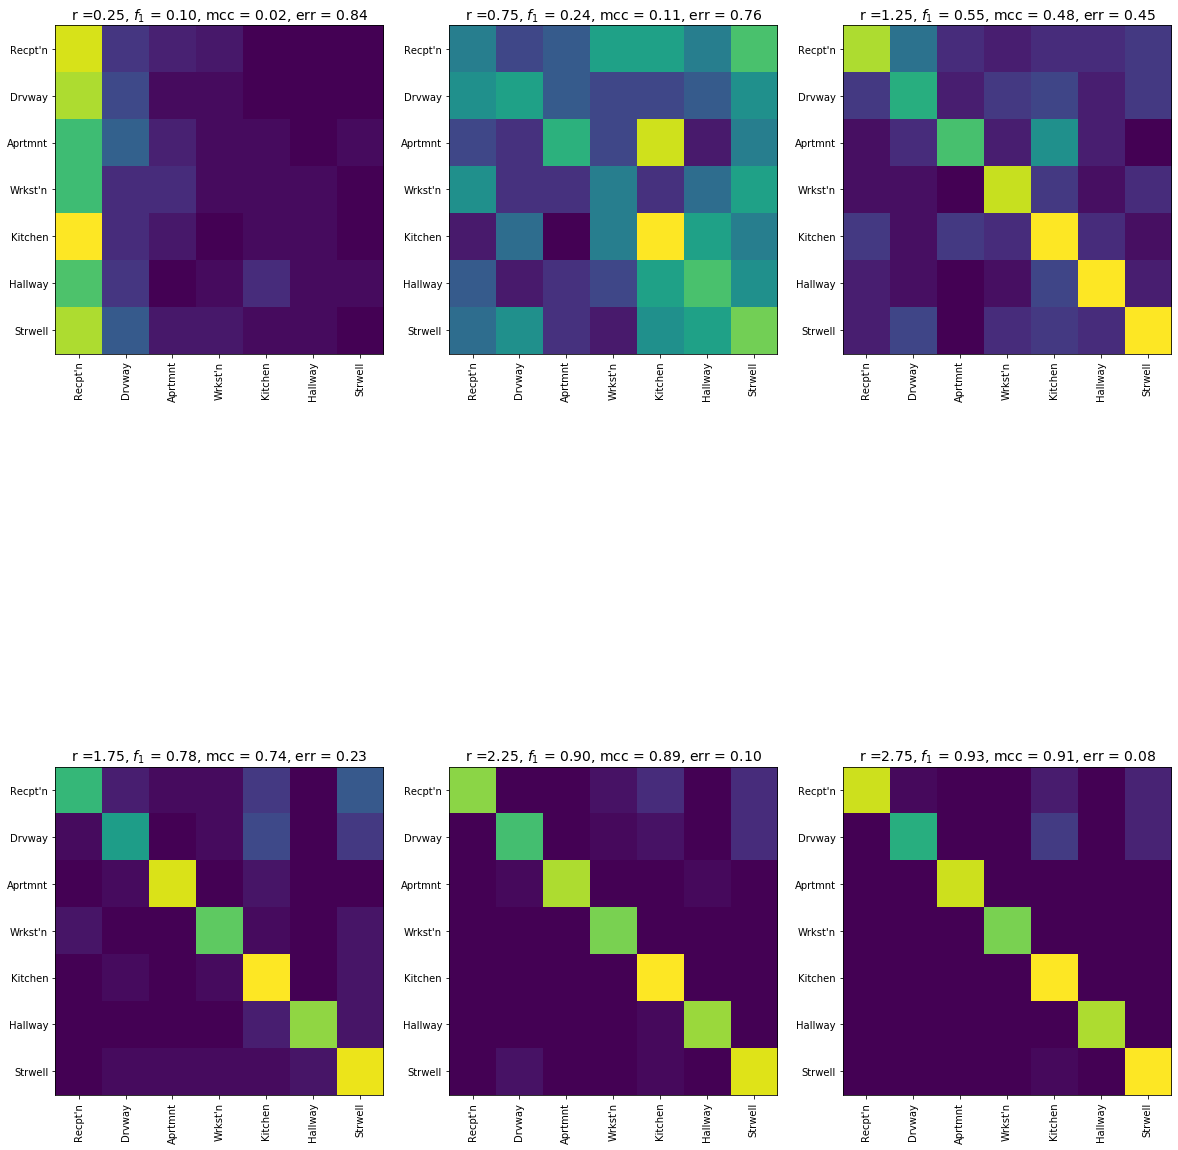

In [70]:
fig=plt.figure(figsize=(20, 25))

plot_count = 1

per_space_score = []
perf_scores = []

#desired_r = [0.5, 1.0, 3.0]

for radius, partial_errors in ransac_errors:

    score_map = np.zeros((7,7))

    for score in partial_errors:
        score_map[int(score[0]),int(score[3])]+=1
        
    macro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    micro_score = f1_score(partial_errors[:,0],partial_errors[:,3],average='micro')
    mcc = matthews_corrcoef(partial_errors[:,0],partial_errors[:,3])
    ave_prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    prec_score = precision_score(partial_errors[:,0],partial_errors[:,3],average=None)
    ave_recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average='macro')
    recl_score = recall_score(partial_errors[:,0],partial_errors[:,3],average=None)
    
    per_space_score.append([
        f1_score(partial_errors[:,0],partial_errors[:,3],average=None),
        prec_score,
        recl_score
    ])
    
    perf_scores.append([
        radius,
        macro_score,
        micro_score,
        mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    ])
    
    ax = fig.add_subplot(2,3,plot_count)
    #print(radius,plot_count)
    title = "r ={:.2f}, $f_1$ = {:.2f}, mcc = {:.2f}, err = {:.2f}".format(
        radius,macro_score,mcc,
        (np.sum(score_map) - np.trace(score_map))/np.sum(score_map)
    )
    ax.set_title(title, fontsize = 14)
    im = ax.imshow(score_map)#, aspect = 30)
    
    ax.set_yticks(np.arange(0,7,1))
    ax.set_yticklabels(contiguous_names_short,fontsize = 10)
    ax.set_xticks(np.arange(0,7,1))
    ax.set_xticklabels(contiguous_names_short,fontsize = 10, rotation = 90)
    
    plot_count +=1
    
per_space_score = np.asarray(per_space_score)
perf_scores = np.asarray(perf_scores)

#plt.savefig('plots/partials-Raw-heatmaps.pdf', format='pdf', dpi=300,bbox_inches = 'tight')

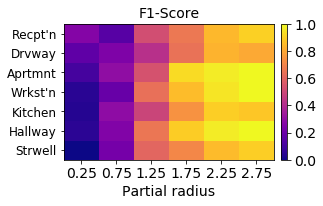

In [88]:
fig=plt.figure(figsize=(4,2.5))

ax1 = fig.add_subplot(1,1,1)

im1 = ax1.imshow(
    per_space_score[:,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.plasma
)

# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="3%", pad=0.1)

# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, ticks=np.arange(0,1.6,0.2), format="%.2f")
#cbar1.ax.set_ylabel("F1-score", fontsize = 14)
cbar1.ax.set_yticklabels(np.arange(0,1.6,0.2, dtype = np.float32),fontsize = 14)

#cbar = plt.colorbar(ticks = np.arange(0,1.1,0.2))
#cbar.ax.set_ylabel("F1-score", fontsize = 14)
#cbar.ax.set_yticklabels(np.arange(0,1.1,0.2, dtype = np.float32),fontsize = 14)

ax1.set_title('F1-Score', fontsize = 14)
ax1.set_xticks(np.arange(0,6))
ax1.set_xticklabels(np.arange(0.25, 3.0, 0.5),fontsize = 14)
ax1.set_xlabel('Partial radius', fontsize = 14)
ax1.set_yticks(np.arange(0,7,1))
#plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)
ax1.set_yticklabels(contiguous_names_short,fontsize = 12)
#plt.yticklabels(

#plt.xlabel('Partial radius', fontsize = 14)
#plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.show()


([<matplotlib.axis.YTick at 0x7fb0f4022a50>,
 <a list of 7 Text yticklabel objects>)

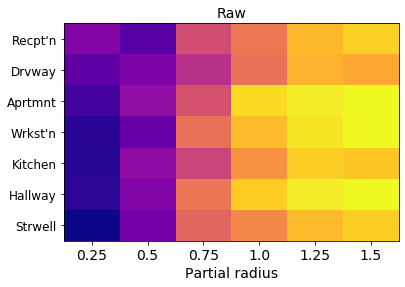

In [76]:
cax0 = divider1.append_axes("left", size="100%", pad=0.1)
p0 = plt.imshow(
    per_space_score[:,0].T,
    vmin=0, vmax=1.0, aspect='auto',
    cmap = plt.cm.plasma
)
plt.title('Raw', fontsize = 14)
plt.xlabel('Partial radius', fontsize = 14)
plt.xticks(np.arange(0,6),np.arange(0.25, 1.6, 0.25),fontsize = 14)
plt.yticks(np.arange(0,7,1),contiguous_names_short,fontsize = 12)

#plt.savefig('plots/partials-F1-score.pdf', format='pdf', dpi=300,bbox_inches = 'tight')